<a href="https://colab.research.google.com/github/arturoduar/detection/blob/main/Pattern_Trainer_Skeleton_TensorFlow_ClassicKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Transfer Learn from ResNet50 

In [5]:
# import only the base of trained model (convolution layers), i.e., --> include_top = False

base_model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False)

In [ ]:
print(base_model.summary())

In [ ]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

In [7]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [12]:
# construct the final dense layers for output of N classes (6 in thid case)

x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
preds = tf.keras.layers.Dense(6, activation = 'softmax')(x)

In [13]:
model = tf.keras.models.Model(inputs = base_model.input, outputs = preds)

In [14]:
# Non trainable part (base layer)

for layer in model.layers[:175]:
    layer.trainable = False

In [15]:
# Trainable part - dense NN 

for layer in model.layers[175:]:
    layer.trainable = True

Load data for classifying N features from images 

Dir structure should be:


    /DataDirectory/
            class1/
            class2/
            ...
            classN/



In [16]:
data_root = ("/content/drive/MyDrive/detect/data/smaller_class_set")


In [17]:
# Image shape down to (224, 224) to match ResNet50

IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)

In [18]:
datagen_kwargs = dict(preprocessing_function= tf.keras.applications.resnet50.preprocess_input, validation_split=.20)

In [19]:
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

valid_generator = valid_datagen.flow_from_directory( TRAINING_DATA_DIR,
                                                    subset="validation",
                                                    shuffle=True,
                                                    color_mode = 'rgb',
                                                    batch_size = 32,
                                                    class_mode = 'categorical',
                                                    target_size=IMAGE_SHAPE)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

train_generator = train_datagen.flow_from_directory( TRAINING_DATA_DIR,
                                                    subset="training",
                                                    shuffle=True,
                                                    color_mode = 'rgb',
                                                    batch_size = 32,
                                                    class_mode = 'categorical',
                                                    target_size=IMAGE_SHAPE)

Found 3117 images belonging to 6 classes.
Found 12487 images belonging to 6 classes.


In [20]:
print (train_generator.class_indices)

{'floral': 0, 'graphics': 1, 'plaid': 2, 'solid': 3, 'spotted': 4, 'striped': 5}


In [21]:
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Do the training

In [22]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit( train_generator, 
                epochs=5,
                #verbose=1,
                steps_per_epoch=steps_per_epoch,
                validation_data=valid_generator,
                validation_steps=val_steps_per_epoch).history

Epoch 1/5
391/391 [==============================] - 4039s 10s/step - loss: 0.8911 - accuracy: 0.6793 - val_loss: 0.8055 - val_accuracy: 0.7267
Epoch 2/5
391/391 [==============================] - 70s 178ms/step - loss: 0.7523 - accuracy: 0.7265 - val_loss: 0.7257 - val_accuracy: 0.7295
Epoch 3/5
391/391 [==============================] - 69s 177ms/step - loss: 0.7024 - accuracy: 0.7468 - val_loss: 0.7292 - val_accuracy: 0.7295
Epoch 4/5
391/391 [==============================] - 70s 178ms/step - loss: 0.6612 - accuracy: 0.7697 - val_loss: 0.7176 - val_accuracy: 0.7642
Epoch 5/5
391/391 [==============================] - 69s 177ms/step - loss: 0.6029 - accuracy: 0.7939 - val_loss: 0.7060 - val_accuracy: 0.7526


In [26]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

98/98 [==============================] - 13s 131ms/step - loss: 0.7060 - accuracy: 0.7526
Final loss: 0.71
Final accuracy: 75.26%


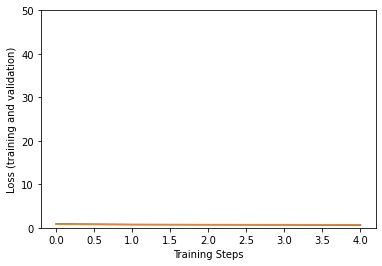

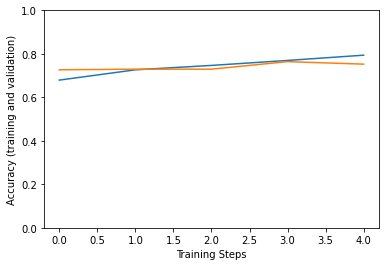

In [28]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,50])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])